In [1]:
import json
import os
from dotenv import load_dotenv
from binance.client import Client
from binance.enums import *
from websocket import WebSocketApp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from interval import *

pd.options.display.float_format = '{:,.6f}'.format

# Ayarları yükle
load_dotenv("api.env")
api_key = os.getenv("API_KEY")
api_secret = os.getenv("API_SECRET")
client = Client(api_key, api_secret)

In [ ]:
KLINE_LIMIT= 63
VOLUME = 200_000
BUY_PRICE = 0
wallet = 0
position = False
inlist = []
tp1 = tp2 = tp3 = stop = 0

In [3]:
def on_error(ws, error):
    print("WebSocket Error:", error)

def on_close(ws, close_status_code, close_msg):
    print("WebSocket connectoin lost.")

def on_open(ws):
    print("WebSocket connection opened.")

In [4]:
def get_pnl_zones(last_price, position = 'long'):
    if position == 'long':
        tp1 = last_price*1.005
        tp2 = last_price*1.01
        tp3 = last_price*1.015
        stop = last_price*0.995
        return tp1,tp2,tp3,stop

In [5]:
def correct(df):
    df = df.copy()
    df = df[['open_time','open','high','low','close','quote_asset_volume']]
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
    df['open_time'] = df['open_time'].dt.tz_convert('Europe/Istanbul')
    df.set_index('open_time', inplace=True)
    df = df.tz_localize(None)
    df[['open','high','low','close','quote_asset_volume']] = df[['open','high','low','close','quote_asset_volume']].apply(pd.to_numeric, errors='coerce')
    df.rename(columns={'quote_asset_volume': 'volume'}, inplace=True)
    df = df.reset_index()
    return df

In [6]:
def is_ath(df):
    prev_max = df['close'].iloc[:-3].max()
    return prev_max if prev_max < df['close'].iloc[-3:].max() else -1

In [7]:
def enhanced_draw(df, ticker, ath):
    last_price = df['close'].iloc[-1]
    last_time  = df['open_time'].iloc[-1]

    plt.figure(figsize=(14, 6))
    plt.plot(df['open_time'], df['close'], label='Real Price', linewidth=1)
    plt.text(last_time, last_price, f' Last Price: {last_price:.5f}', color='orange', fontsize=10)

    plt.axhline(ath, linestyle='--', label='Previous ATH')
    plt.text(df['open_time'].iloc[0], ath, f' Prev ATH: {ath:.5f}',
            va='bottom', ha='left', fontsize=9)

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=20))
    plt.xticks(rotation=45)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.title(f"{ticker} – ATH Scan")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def get_new_row(k):
    ts = pd.to_datetime(k['t'], unit='ms', utc=True) \
         .tz_convert('Europe/Istanbul') \
         .tz_localize(None)
    new_row = {
        'open_time': ts,
        'open': float(k['o']),
        'high': float(k['h']),
        'low': float(k['l']),
        'close': float(k['c']),
        'volume': float(k['q']),
    }
    return new_row

In [9]:
def get_prev(symbol):
    try:
        klines = client.futures_klines(
            symbol=symbol,
            interval=Client.KLINE_INTERVAL_1MINUTE,
            limit=KLINE_LIMIT
        )
        df = pd.DataFrame(klines, columns=[
            "open_time","open","high","low","close","volume",
            "close_time","quote_asset_volume","num_trades",
            "taker_buy_base","taker_buy_quote","ignore"
        ])
        df = correct(df)
        return df
    except Exception as e:
        print(f"[ERROR] {symbol} fetch failed: {e}")
        return None

In [10]:
def stg_implementation(symbol, inlist, df):
    global position
    
    avg_vol_10 = df['volume'].iloc[-10:].mean()
    if avg_vol_10 <= VOLUME:
        return False
    
    last_price = df['close'].iloc[-1]
    ath = is_ath(df)
        
    if ath != -1 and symbol not in inlist:
        inlist.append(symbol)
        if not position:
            print(f"{symbol} | Price: {last_price} | AvgVol10: {avg_vol_10:.0f}")
            tp1, tp2, tp3, stop = get_pnl_zones(last_price)
            print(f'TP1: {tp1:.6f} | TP2: {tp2:.6f} | TP3: {tp3:.6f}\nStop: {stop:.6f}')
            enhanced_draw(df, ticker=symbol, ath=ath)
            get_int([symbol])


In [ ]:
current_ts = None
symbols_updated = set()

def process_kline(sym, df_container, inlist):
    global current_ts, symbols_updated

    ts = df_container[sym]['open_time'].iloc[-1]

    if ts != current_ts:
        current_ts = ts
        symbols_updated.clear()

    symbols_updated.add(sym)

    if len(symbols_updated) == len(df_container):
        print(f"All symbols are updated: {current_ts}. Starting scan.")
        for s, df_sym in df_container.items():
            stg_implementation(symbol=s, inlist=inlist, df=df_sym)
        print("\033[92mScanning finished, inlist:", inlist, "\033[0m")
        symbols_updated.clear()

In [12]:
took_tp1 = False
took_tp2 = False
took_tp3 = False
stopped = False

def track_order(symbol, k, tp1, tp2, tp3, stop):
    global took_tp1
    global took_tp2
    global took_tp3
    global wallet
    global inlist
    global position


    if k['low']<= stop and not took_tp1:
        wallet -= 1.5
        print('Closed position, stop condition triggered price got down to',k['low'], 'Current wallet:',wallet)
        position = False
        inlist = []    
    elif k['low']<= stop:
        inlist=[]
        print('Closing position at entry price, price got down to', k['low'], 'Current Wallet',wallet)
        took_tp1 = False
        took_tp2 = False
        took_tp3 = False
        position = False

    else:
        if k['high']>= tp1 and not took_tp1:
            wallet+=0.5
            took_tp1=True
            print('took profit1', wallet,'at price:',k['high'])
        if k['high']>= tp2 and not took_tp2:
            wallet+=1
            took_tp2 =True
            print('took profit2', wallet,'at price:',k['high'])
        if k['high']>= tp3 and not took_tp3:
            wallet +=1.5
            took_tp3 = True
            inlist = []
            print('took profit3', wallet,'at price:',k['high'])
            position = False
            took_tp1 = False
            took_tp2 = False
            took_tp3 = False
    

In [13]:

def on_message(df_container, ws, message):
    global took_tp1
    global BUY_PRICE
    global position
    global tp1, tp2, tp3, stop 
    
    payload = json.loads(message)
    data    = payload['data']
    sym     = data['s'].lower()
    k       = data['k']

    if inlist and not position:
        if sym ==inlist[0]:
            position = True
            BUY_PRICE = float(k['c'])
            tp1, tp2, tp3, stop = get_pnl_zones(BUY_PRICE)
            print(f'Opening position: {inlist[0]} | price: {BUY_PRICE}')

    if position and inlist:
        if sym ==inlist[0]:
            row = get_new_row(k)
            if took_tp1:
                stop = BUY_PRICE
            track_order(symbol=inlist[0],k=row,tp1=tp1, tp2=tp2, tp3=tp3, stop=stop)

    if not k['x']:
        return

    new_row = get_new_row(k)
    df       = df_container[sym]
    last_time = df['open_time'].iloc[-1]

    if new_row['open_time'] > last_time:
        updated = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
    else:
        updated = pd.concat([df.iloc[:-1], pd.DataFrame([new_row])], ignore_index=True)

    df_container[sym] = updated


    process_kline(sym, df_container, inlist)

There are 518 symbols, downloading historical data
btcusdt is downloaded
xmrusdt is downloaded
etcusdt is downloaded
xlmusdt is downloaded
ethusdt is downloaded
xrpusdt is downloaded
adausdt is downloaded
linkusdt is downloaded
trxusdt is downloaded
dashusdt is downloaded
bchusdt is downloaded
ltcusdt is downloaded
zecusdt is downloaded
xtzusdt is downloaded
bnbusdt is downloaded
atomusdt is downloaded
ontusdt is downloaded
batusdt is downloaded
iotausdt is downloaded
qtumusdt is downloaded
vetusdt is downloaded
neousdt is downloaded
iostusdt is downloaded
thetausdt is downloaded
algousdt is downloaded
zilusdt is downloaded
kncusdt is downloaded
zrxusdt is downloaded
omgusdt is downloaded
compusdt is downloaded
dogeusdt is downloaded
sxpusdt is downloaded
bandusdt is downloaded
rlcusdt is downloaded
balusdt is downloaded
snxusdt is downloaded
kavausdt is downloaded
mkrusdt is downloaded
yfiusdt is downloaded
wavesusdt is downloaded
defiusdt is downloaded
dotusdt is downloaded
solusdt i

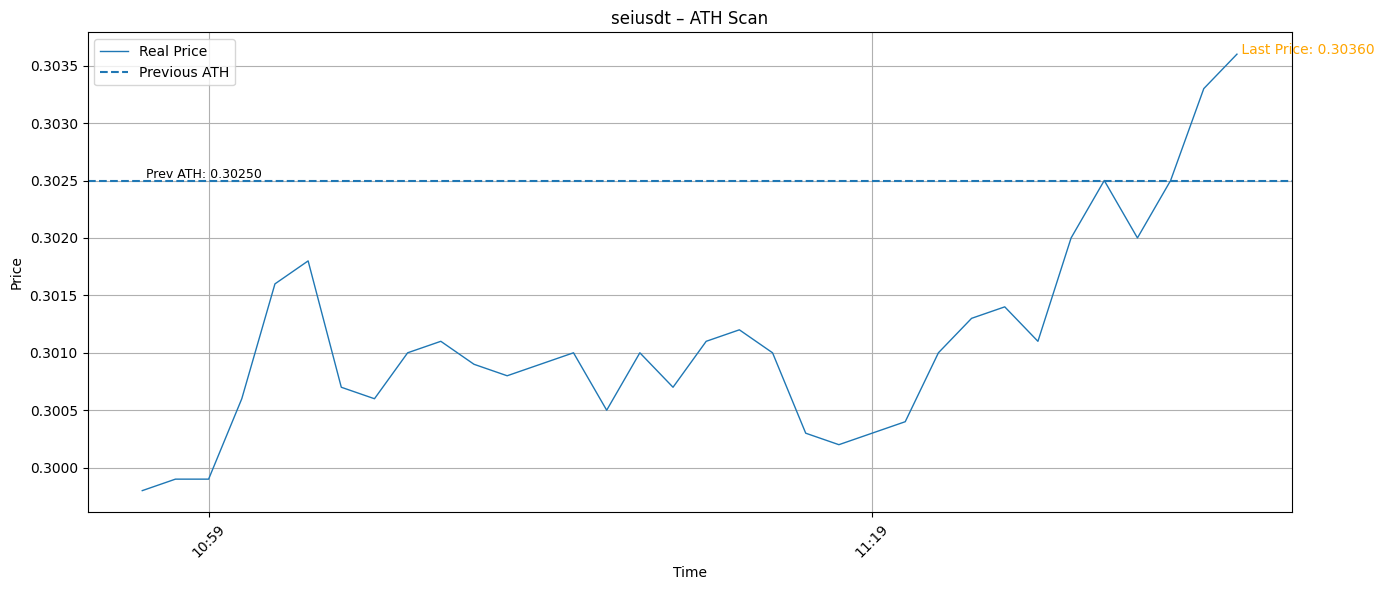

seiusdt 0.02169789414576495


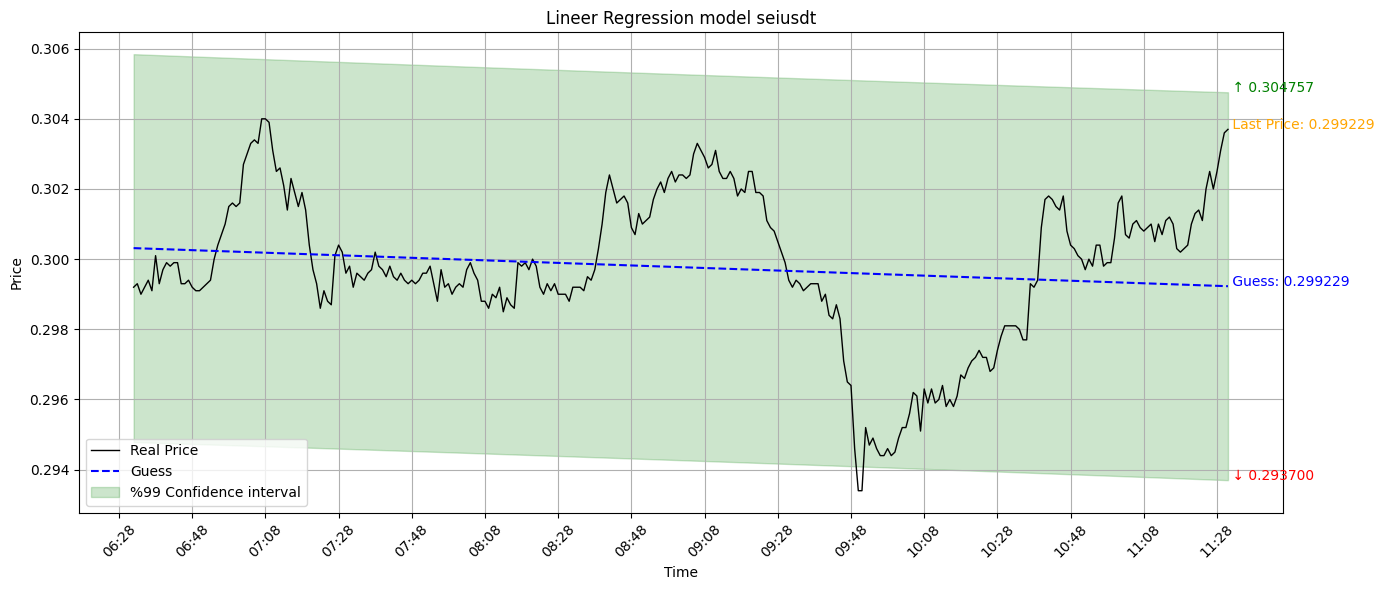

Scanning finished, inlist: ['seiusdt'] 
Opening position: seiusdt | price: 0.3036


In [ ]:
if __name__ == "__main__":
    info    = client.futures_exchange_info()
    symbols = [
        s['symbol'].lower()
        for s in info['symbols']
        if s.get('contractType') == 'PERPETUAL'
    ]

    from concurrent.futures import ThreadPoolExecutor, as_completed

    df_container = {}
    print(f"There are {len(symbols)} symbols, downloading historical data")
    with ThreadPoolExecutor(max_workers=10) as exe:
        futures = {exe.submit(get_prev, sym): sym for sym in symbols}
        for fut in as_completed(futures):
            sym = futures[fut]
            df  = fut.result()
            if df is not None:
                df_container[sym] = df
                print(f"{sym} is downloaded")
    print("All historical data has been downloaded. Continuing with live data")

    print("Connecting to websocket")
    streams   = "/".join(f"{sym}@kline_1m" for sym in symbols)
    socket_url = f"wss://fstream.binance.com/stream?streams={streams}"

    ws = WebSocketApp(
        socket_url,
        on_open=on_open,
        on_error=on_error,
        on_close=on_close,
        on_message=lambda ws, msg: on_message(df_container, ws, msg)
    )

    ws.run_forever()